# Tutorial: Automatic differentiation variational inference (ADVI)

This tutorial demonstrates the automatic differentiation variational inference (ADVI) `AutoGuideVI` implementation.
It assumes a variational family which mean-field factorizes into a product of Gaussians: $$q(z) = \prod_i N(z_i; \mu_i, \sigma_i)$$
ADVI is a convenient way to perform VI and obtain distributional estimates which
include uncertainty. It is appropriate when posteriors are expected to be close to a product of
Normals.

# Prerequisites

In [ ]:
# Install Bean Machine in Colab if using Colab.
import sys


if "google.colab" in sys.modules and "beanmachine" not in sys.modules:
    !pip install beanmachine

In [1]:
import torch.distributions as dist
import beanmachine.ppl as bm
import torch
from beanmachine.ppl.inference.vi import ADVI

In [ ]:
import os

# Plotting settings
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("lines", linewidth=2.5)

# Manual seed
bm.seed(11)
torch.manual_seed(11)

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

## ADVI on a Normal-Normal model

This example considers a Normal-Normal model where both the prior $\mu \sim N(0, 10)$ and observation model $x \mid \mu \sim N(\mu, 1)$ are Normal distributions. All of ADVI's
assumptions are satisfied in this setting.

In [2]:
std_0 = 10. # scale for mu
std_x = 1. # scale for observations x(i)

@bm.random_variable
def mu():
    return dist.Normal(
        torch.zeros(1), std_0 * torch.ones(1)
    )

@bm.random_variable
def x(i):
    return dist.Normal(mu(), std_x * torch.ones(1))

observations = {x(i): torch.tensor(1.0) for i in range(10)}

The posterior distribution $\mu \mid x$ is Gaussian due to conjugacy.
Below, we [use conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)
to compute its location and scale in closed form

In [3]:
expected_variance = 1 / (
    (std_0**-2) + (sum(observations.values()) / std_x**2)
)
expected_std = torch.sqrt(expected_variance)
expected_mean = expected_variance * (
    (sum(observations.values()) / std_x**2)
)
print(expected_mean, expected_std)

tensor(0.9990) tensor(0.3161)


ADVI makes a mean-field assumption, but this does not matter since there is a single 1-dimensional latent random variable.
It also uses a Gaussian variational approximation, but this is appropriate for this example since by conjugacy we know
this assumption is valid. Hence, we expect ADVI to yield a good approximation:

In [4]:
v_world = ADVI(queries=[mu()], observations=observations,).infer(
    num_steps=1000,
)
print(v_world.get_guide_distribution(mu()))

  0%|          | 0/1000 [00:00<?, ?it/s]

Normal(loc: tensor([1.0570], requires_grad=True), scale: tensor([0.3229], grad_fn=<SoftplusBackward0>))


Below we visualize the density functions for the target and the ADVI approximation.

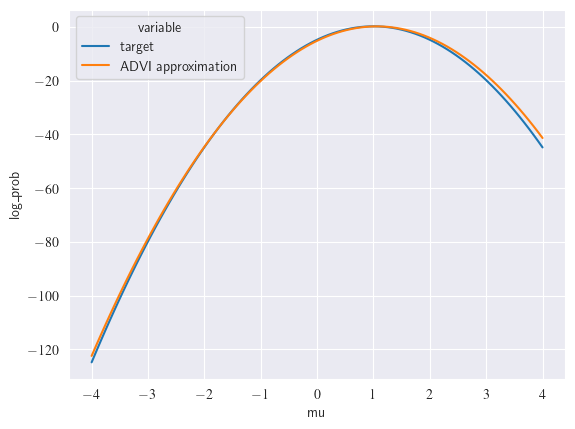

In [13]:
import pandas as pd
import seaborn as sns


sns.set_style('darkgrid')

with torch.no_grad():
    xs = torch.linspace(-4, 4, steps=100)
    sns.lineplot(
        data=pd.DataFrame({
            'mu': xs,
            'target': dist.Normal(expected_mean, expected_std).log_prob(xs),
            'ADVI approximation': v_world.get_guide_distribution(mu()).log_prob(xs),
        }).melt(id_vars=['mu'], value_name='log_prob'),
        x='mu',
        y='log_prob',
        hue='variable',
    )
